In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.utils.class_weight import compute_class_weight


##### Query for downloading the data from Google Cloud BIGQUERY

##### The dataset was downloaded as csv and later uploaded in Visual Studio where futher processing was performed

In [2]:
#importing dataset by reading csv file (The data was downloaded from Google Cloud using BIGQUERY)
df=pd.read_csv('/root/code/thesis/codeFolder/LatestDataInUse/csv/7learnings.csv', parse_dates=['formatted_date'])

/tmp/ipykernel_576764/1697213116.py:2: DtypeWarning: Columns (20) have mixed types. Specify dtype option on import or set low_memory=False.
  df=pd.read_csv('/root/code/thesis/codeFolder/LatestDataInUse/csv/7learnings.csv', parse_dates=['formatted_date'])


In [3]:
df.head()

,station_number,wban_number,year,month,day,mean_temp,num_mean_temp_samples,mean_dew_point,num_mean_dew_point_samples,mean_sealevel_pressure,...,min_temperature_explicit,total_precipitation,snow_depth,fog,rain,snow,hail,thunder,tornado,formatted_date
0,725940,99999,2005,1,25,51.299999,4,45.299999,4.0,1013.500000,...,NaN,0.00,NaN,False,False,False,False,False,False,2005-01-25
1,725940,99999,2005,3,7,51.500000,4,48.000000,4.0,1025.000000,...,NaN,0.00,NaN,False,False,False,False,False,False,2005-03-07
2,725940,99999,2005,5,11,51.000000,4,45.700001,4.0,1021.799988,...,NaN,0.01,NaN,False,False,False,False,False,False,2005-05-11
3,725869,99999,2005,1,27,30.200001,5,26.600000,5.0,NaN,...,NaN,0.00,NaN,False,False,False,False,False,False,2005-01-27
4,725827,99999,2005,10,23,55.000000,5,28.799999,5.0,1015.599976,...,NaN,0.00,NaN,False,False,False,False,False,False,2005-10-23


# Data Preprocessing

In [4]:
# Filtering stations 725300 to 725330 that have information from 2005 till 2009.
df = df[(df['station_number'] >= 725300) & (df['station_number'] <= 725330)]

# Specify the columns to drop 
# Some of these column like were irrelevant, some coulumns had missing values
columns_to_drop = ['min_temperature', 'min_temperature_explicit','mean_station_pressure','mean_sealevel_pressure', 'num_mean_station_pressure_samples','year','month','day','snow_depth', 'num_mean_sealevel_pressure_samples', 'wban_number', 'num_mean_temp_samples','num_mean_dew_point_samples', 'num_mean_visibility_samples' ,'max_sustained_wind_speed','max_gust_wind_speed','max_temperature_explicit', 'num_mean_wind_speed_samples','tornado','max_temperature']

# Drop the specified columns
df_dropped = df.drop(columns=columns_to_drop)


In [5]:
# Checking columns with NAN values
columns_with_nan = df_dropped.columns[df_dropped.isna().any()].tolist()

print(columns_with_nan)


['mean_wind_speed', 'total_precipitation']


### Strategies for dealing with missing values

In [6]:
#### Strategy 1: Filling the missing values with mean values
#data.fillna(data.mean(), inplace=True)

### Strategy 2: Interpolating the missing values
#df_dropped['mean_wind_speed'] = df_dropped['mean_wind_speed'].interpolate()
#df_dropped['total_precipitation'] = df_dropped['total_precipitation'].interpolate()
#df_dropped['mean_sealevel_pressure'] = df_dropped['mean_sealevel_pressure'].interpolate()

### Strategy 3: Droping the missing rows
df_dropped=df_dropped.dropna()

##### Droping the rows with missing values reduces data size but other strategies are more likely to compromise data quality

In [7]:
# Sorting the dataframe with respect to data and resting the dataframe index
final_df = df_dropped.sort_values(by='formatted_date') 
final_df=final_df.set_index('formatted_date')

In [8]:
final_df.head(5)

,station_number,mean_temp,mean_dew_point,mean_visibility,mean_wind_speed,total_precipitation,fog,rain,snow,hail,thunder
formatted_date,,,,,,,,,,,
2005-01-02,725314,60.799999,57.599998,8.9,4.8,0.40,False,False,False,False,False
2005-01-04,725300,32.299999,29.400000,7.7,9.3,0.34,True,True,True,True,True
2005-01-07,725330,24.799999,20.400000,9.7,7.7,0.03,False,False,False,False,False
2005-01-07,725305,16.700001,13.100000,8.4,6.9,0.01,False,False,False,False,False
2005-01-08,725316,28.600000,25.500000,7.3,5.4,0.10,True,True,True,True,True


## Visualizing the Data

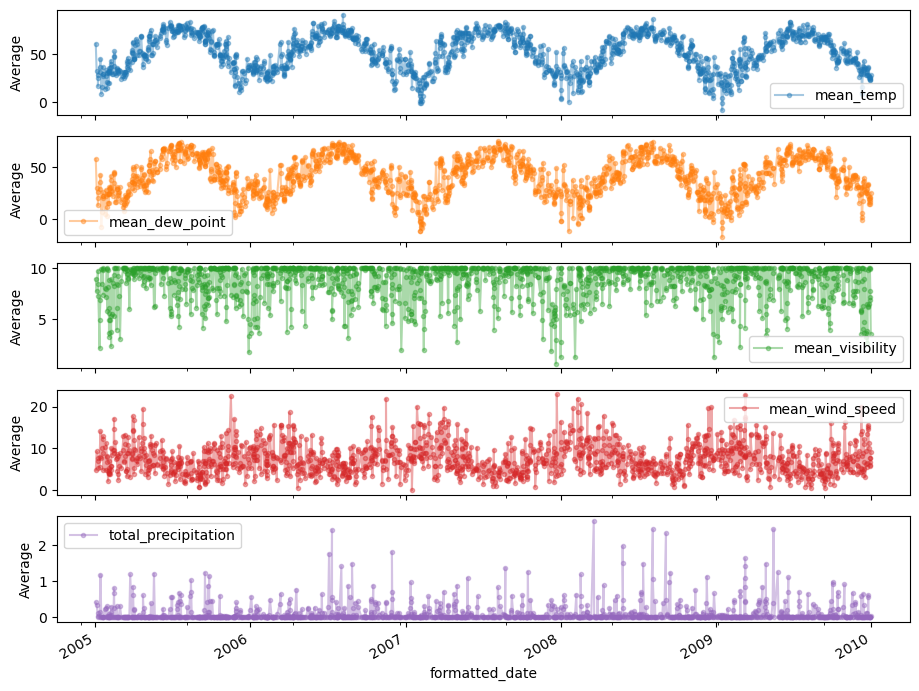

In [9]:
cols_plot = ['mean_temp', 'mean_dew_point', 'mean_visibility', 'mean_wind_speed','total_precipitation']
axes = final_df[cols_plot].plot(marker='.', alpha=0.4, linestyle='-', 
        figsize=(11, 9), subplots=True, title='')
for ax in axes:
    ax.set_ylabel('Average')


In [10]:
final_df.columns   

Index(['station_number', 'mean_temp', 'mean_dew_point', 'mean_visibility',
       'mean_wind_speed', 'total_precipitation', 'fog', 'rain', 'snow', 'hail',
       'thunder'],
      dtype='object')

In [11]:
# Converting categorical features to numerical features
final_df['fog'] = final_df['fog'].astype(int)
final_df['rain'] = final_df['rain'].astype(int)
final_df['hail'] = final_df['hail'].astype(int)
final_df['thunder'] = final_df['thunder'].astype(int)
final_df['snow'] = final_df['snow'].astype(int)

In [12]:
# Create the target variable 'snow_tomorrow'
final_df['snow_tomorrow'] = final_df.groupby('station_number')['snow'].shift(-1)
final_df.dropna(inplace=True)

In [13]:
final_df

,station_number,mean_temp,mean_dew_point,mean_visibility,mean_wind_speed,total_precipitation,fog,rain,snow,hail,thunder,snow_tomorrow
formatted_date,,,,,,,,,,,,
2005-01-02,725314,60.799999,57.599998,8.9,4.8,0.40,0,0,0,0,0,0.0
2005-01-04,725300,32.299999,29.400000,7.7,9.3,0.34,1,1,1,1,1,0.0
2005-01-07,725330,24.799999,20.400000,9.7,7.7,0.03,0,0,0,0,0,1.0
2005-01-07,725305,16.700001,13.100000,8.4,6.9,0.01,0,0,0,0,0,0.0
2005-01-08,725316,28.600000,25.500000,7.3,5.4,0.10,1,1,1,1,1,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2009-12-24,725330,28.400000,22.000000,9.8,15.6,0.01,0,0,0,0,0,0.0
2009-12-25,725327,35.900002,33.000000,6.3,14.6,0.54,0,0,0,0,0,0.0
2009-12-25,725305,36.599998,33.400002,6.2,15.1,0.61,0,0,0,0,0,0.0


In [14]:
final_df['snow'].value_counts()

0    1340
1     174
Name: snow, dtype: int64

### The dataset has huge class imbalance with 1350 values representing class 0 "no snow" and only 174 values prepresenting class 1 "snow"

In [15]:
# Group by 'station_number' and count the number of entries for each station
station_counts = final_df.groupby('station_number').size().reset_index(name='counts')

# Display the station counts
print(station_counts)

   station_number  counts
0          725300     141
1          725305     148
2          725314     149
3          725315     145
4          725316     149
5          725317     160
6          725320     147
7          725326     171
8          725327     152
9          725330     152


## Train Test Split

In [16]:
# Train-test split, ensuring the split is done per station to maintain the time series nature
def train_test_split_per_station(df, test_size=0.2):
    train_data = pd.DataFrame()
    test_data = pd.DataFrame()
    for station in df['station_number'].unique():
        station_data = df[df['station_number'] == station]
        train_station, test_station = train_test_split(station_data, test_size=test_size, shuffle=False)
        train_data = pd.concat([train_data, train_station])
        test_data = pd.concat([test_data, test_station])
    return train_data, test_data

In [17]:
train_data, test_data = train_test_split_per_station(final_df)

features = ['mean_temp', 'mean_dew_point', 'mean_visibility', 'mean_wind_speed',
        'total_precipitation', 'fog', 'rain', 'hail', 'thunder','snow']

X_train = train_data[features]
y_train = train_data['snow_tomorrow']
X_test = test_data[features]
y_test = test_data['snow_tomorrow']

In [18]:
# Standardize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [19]:
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y.values, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

## Model

In [20]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        h_0 = torch.zeros(self.lstm.num_layers, x.size(0), self.lstm.hidden_size).to(x.device)
        c_0 = torch.zeros(self.lstm.num_layers, x.size(0), self.lstm.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h_0, c_0))
        out = self.fc(out[:, -1, :])
        out = self.sigmoid(out)
        return out



## Taining and Testing the model

In [30]:
train_dataset = TimeSeriesDataset(X_train_scaled, y_train)
test_dataset = TimeSeriesDataset(X_test_scaled, y_test)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Flatten y_train to ensure it's a 1D array
y_train_flat = y_train.values.flatten()

# Convert to int
y_train_int = y_train_flat.astype(int)

# Calculate class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train_int), y=y_train_int)
class_weights = torch.tensor(class_weights, dtype=torch.float32)

# Use class weights in the loss function
criterion = nn.BCEWithLogitsLoss(pos_weight=class_weights[1])

input_size = X_train_scaled.shape[1]
hidden_size = 200
num_layers = 2
model = LSTMModel(input_size, hidden_size, num_layers)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay= 0.1)

num_epochs = 100

# Lists to store losses and accuracies
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

In [31]:
for epoch in range(num_epochs):
    # Training
    model.train()
    train_loss = 0
    correct_train = 0
    total_train = 0
    
    for inputs, labels in train_loader:
        inputs = inputs.unsqueeze(1).to(device)
        labels = labels.to(device).unsqueeze(1)
        
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        
        predicted = (outputs > 0.5).float()
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
    
    train_loss /= len(train_loader)
    train_accuracy = correct_train / total_train*100
    
    # Evaluation
    model.eval()
    test_loss = 0
    correct_test = 0
    total_test = 0
    
    all_labels = []
    all_predictions = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.unsqueeze(1).to(device)
            labels = labels.to(device).unsqueeze(1)
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            
            predicted = (outputs > 0.5).float()
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()
            
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())
    
    test_loss /= len(test_loader)
    test_accuracy = correct_test / total_test*100

    # Store losses and accuracies
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)
    
    # Print epoch results
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')    

Epoch [1/100], Train Loss: 1.1036, Train Accuracy: 11.5162, Test Loss: 1.0861, Test Accuracy: 10.0977
Epoch [2/100], Train Loss: 1.1026, Train Accuracy: 11.5162, Test Loss: 1.0854, Test Accuracy: 10.0977
Epoch [3/100], Train Loss: 1.1018, Train Accuracy: 11.5162, Test Loss: 1.0849, Test Accuracy: 10.0977
Epoch [4/100], Train Loss: 1.1017, Train Accuracy: 11.5162, Test Loss: 1.0845, Test Accuracy: 10.0977
Epoch [5/100], Train Loss: 1.1013, Train Accuracy: 11.5162, Test Loss: 1.0841, Test Accuracy: 10.0977
Epoch [6/100], Train Loss: 1.1010, Train Accuracy: 11.5162, Test Loss: 1.0838, Test Accuracy: 10.0977
Epoch [7/100], Train Loss: 1.1007, Train Accuracy: 11.5162, Test Loss: 1.0835, Test Accuracy: 10.0977
Epoch [8/100], Train Loss: 1.1008, Train Accuracy: 11.5162, Test Loss: 1.0831, Test Accuracy: 10.0977
Epoch [9/100], Train Loss: 1.1005, Train Accuracy: 11.5162, Test Loss: 1.0829, Test Accuracy: 10.0977
Epoch [10/100], Train Loss: 1.0992, Train Accuracy: 11.5162, Test Loss: 1.0826, Te

In [32]:
# Classification Report
print("Classification Report:")
print(classification_report(all_labels, all_predictions, target_names=['No Snow', 'Snow']))

Classification Report:
              precision    recall  f1-score   support

     No Snow       0.90      1.00      0.95       276
        Snow       0.00      0.00      0.00        31

    accuracy                           0.90       307
   macro avg       0.45      0.50      0.47       307
weighted avg       0.81      0.90      0.85       307



/opt/conda/envs/usama/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/envs/usama/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/envs/usama/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


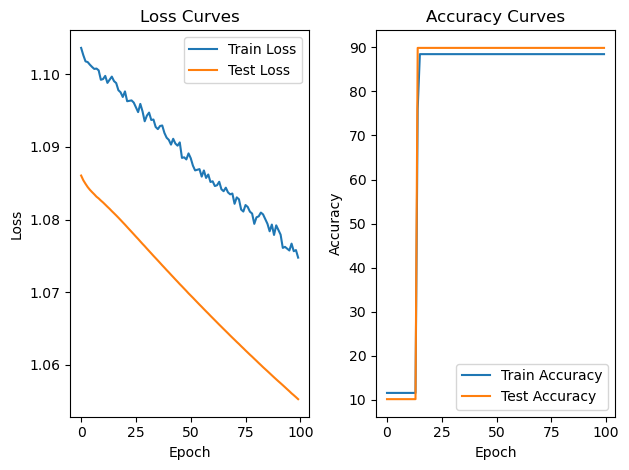

In [33]:
# Plot loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curves')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Curves')
plt.legend()

plt.tight_layout()
plt.show()